In [1]:
import pickle
from typing import Iterator, Literal

import cheetah
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from tqdm import trange

In [2]:
torch.manual_seed(42)

In [3]:
plt.style.use(["science", "ieee", "no-latex"])

# Some SGD and AutoDiff stuff

- Underlying most of machine learning today
- SGD in simple terms
- Need gradient ... complicated to compute ... easy with AutoDiff
- Frameworks with that come with AutoDiff: TensorFlow, PyTorch, JAX, etc.
- Used for stuff in other fields: fluid dynamics, topology optimisation etc.

-> Conclude beam dynamics simulator with AutoDiff support (and "differentiable", i.e. useful gradients / smooth-ish)

- Go into "differentiable" meaning "has AutoDiff and useful gradients"

- _Cheetah_
  - General introduction
  - Mention also fast as prerequisite for reinforcement learning
  - Show contributors slide
  - Maybe some facts? No. downloads, starts ...?


## What is gradient-based optimisation?

- Known from ML ... NN training


## AutoDiff

- What is it? ... graph image
- Frameworks


## Other fields


## Cheetah overview


## Tracking through a simple lattice

In this example, we create a custom lattice and track a beam through it. We start with some imports.


Lattices in _Cheetah_ are represented by `Segments`. A `Segment` is created as follows.


In [4]:
ares_ea = cheetah.Segment(
    elements=[
        cheetah.Drift(length=torch.tensor(0.1750)),
        cheetah.Quadrupole(
            length=torch.tensor(0.1220), k1=torch.tensor(0.0), name="AREAMQZM1"
        ),
        cheetah.Drift(length=torch.tensor(0.4280)),
        cheetah.Quadrupole(
            length=torch.tensor(0.1220), k1=torch.tensor(0.0), name="AREAMQZM2"
        ),
        cheetah.Drift(length=torch.tensor(0.2040)),
        cheetah.VerticalCorrector(
            length=torch.tensor(0.0200), angle=torch.tensor(0.0), name="AREAMCVM1"
        ),
        cheetah.Drift(length=torch.tensor(0.2040)),
        cheetah.Quadrupole(
            length=torch.tensor(0.1220), k1=torch.tensor(0.0), name="AREAMQZM3"
        ),
        cheetah.Drift(length=torch.tensor(0.1790)),
        cheetah.HorizontalCorrector(
            length=torch.tensor(0.0200), angle=torch.tensor(0.0), name="AREAMCHM1"
        ),
        cheetah.Drift(length=torch.tensor(0.4500)),
        cheetah.Screen(
            resolution=[2448, 2040],
            pixel_size=torch.tensor([3.5488e-06, 2.5003e-06]),
            binning=1,
            method="kde",
            is_active=False,
            name="AREABSCR1",
        ),
    ]
)

**Note** that many values must be passed to lattice elements as `torch.Tensor`s. This is because _Cheetah_ uses automatic differentiation to compute the gradient of the beam position at the end of the lattice with respect to the element strengths. This is necessary for gradient-based magnet setting optimisation.

Named lattice elements (i.e. elements that were given a `name` keyword argument) can be accessed by name and their parameters changed like so.


In [5]:
ares_ea.AREAMQZM2.k1 = torch.tensor(4.2)

Next, we create a beam to track through the lattice. In this particular example, we import a beam from an Astra particle distribution file. Note that we are using a `ParticleBeam` here, which is a beam defined by individual particles. This is the most precise way to track a beam through a lattice, but also slower than the alternative `ParameterBeam` which is defined by the beam's parameters. Instead of importing beams from other simulation codes, you can also create beams from scratch, either using their parameters or their Twiss parameters.


In [6]:
incoming_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001")

In order to track a beam through the segment, simply call the segment's `track` method.


In [7]:
outgoing_beam = ares_ea.track(incoming_beam)

You may plot a segment with reference particle traces bay calling


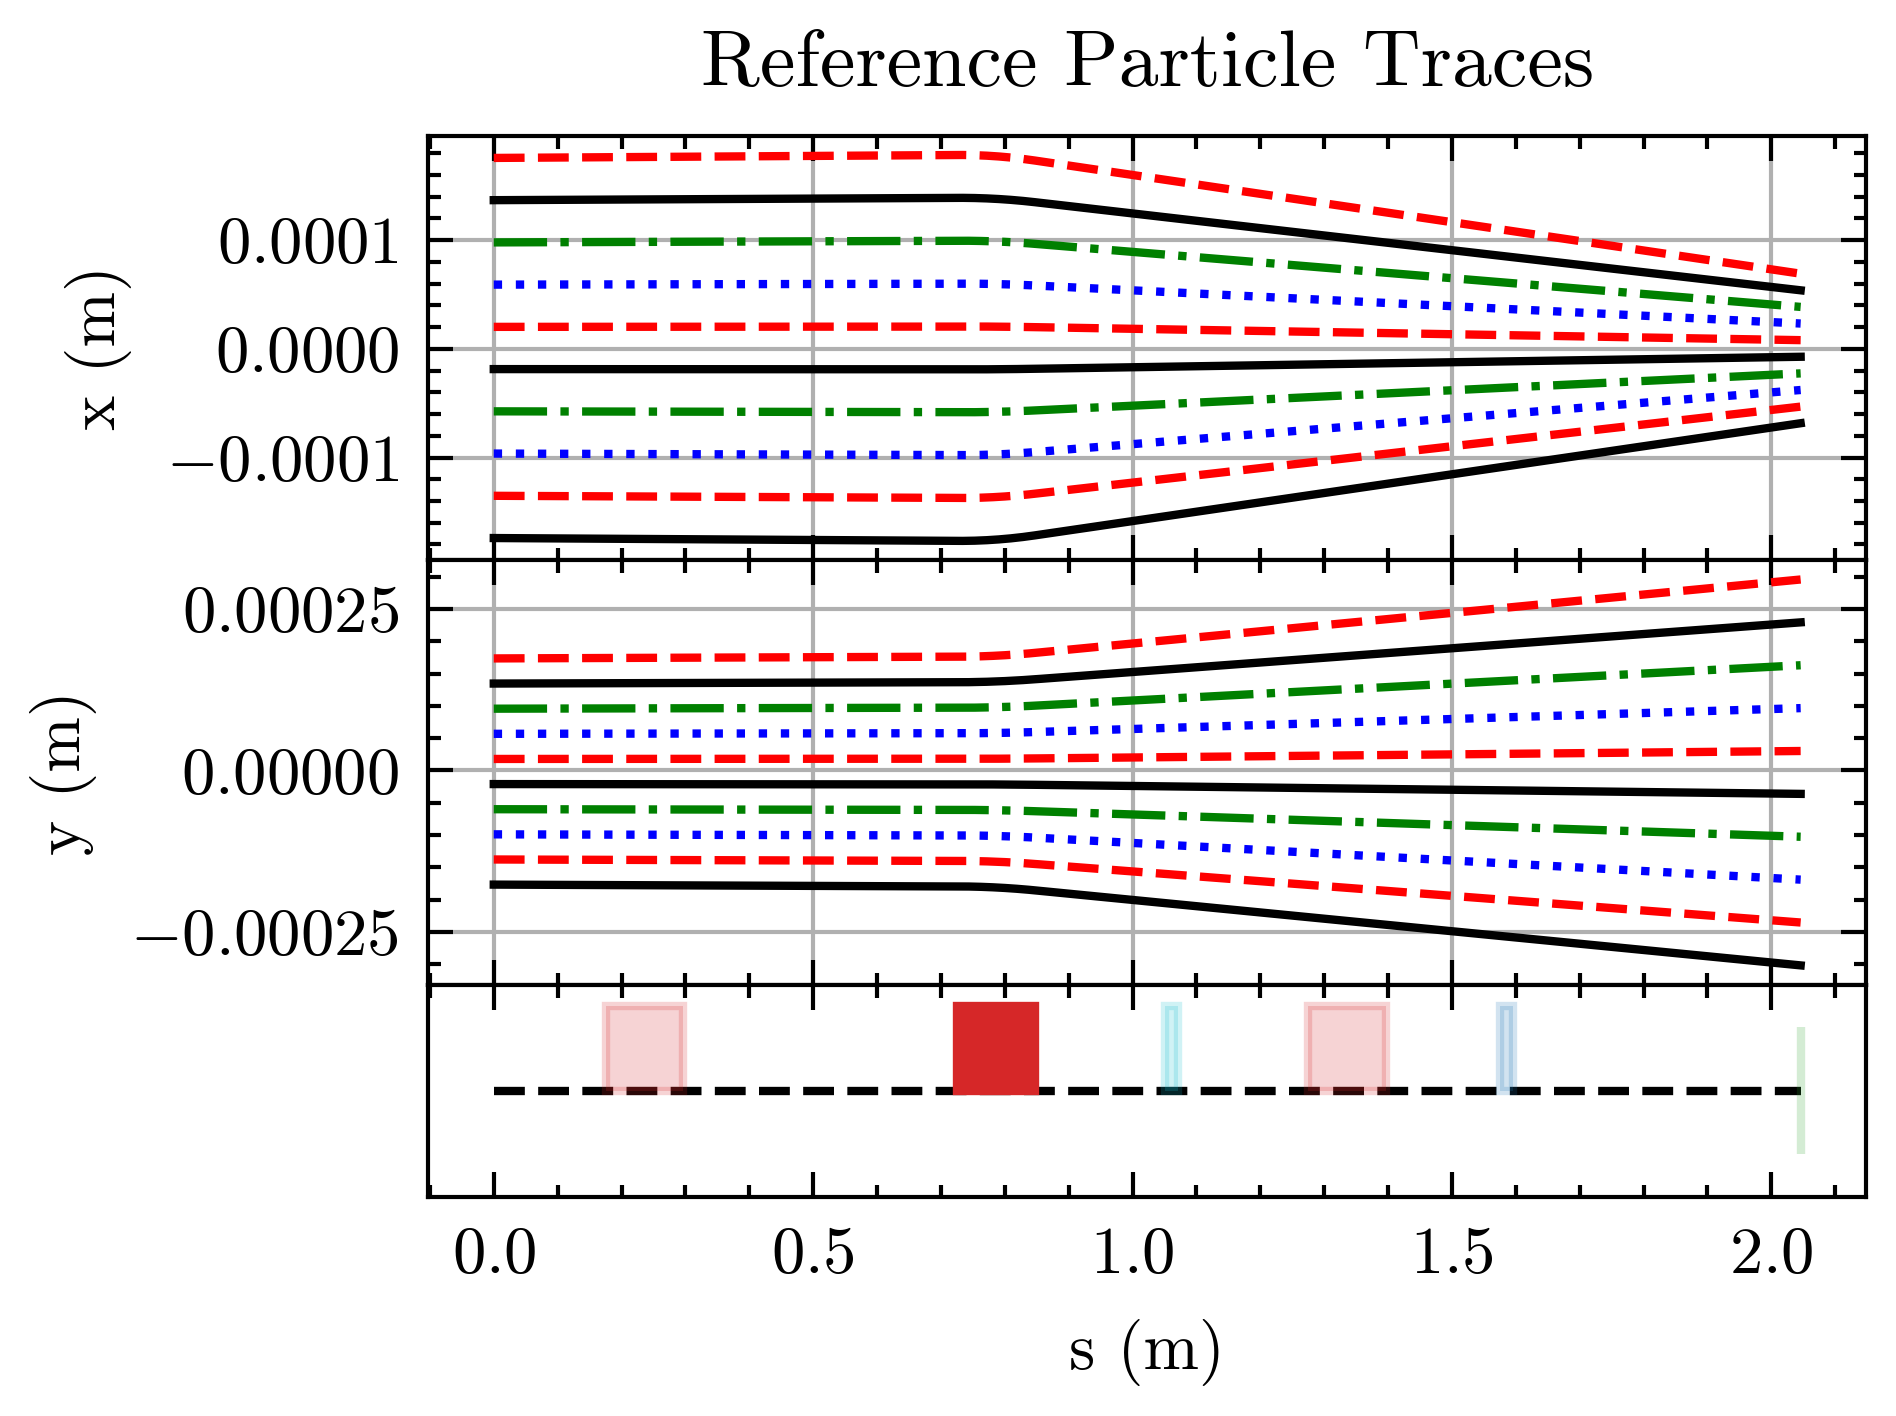

In [8]:
ares_ea.plot_overview(incoming=incoming_beam)

# Gradient-based optimisation using _Cheetah_ and _PyTorch_

_Cheetah_ is a differentiable beam dynamics simulation engine, making it ideally suited to gradient-based optimisation, for example for optimisation magnet settings, lattice geometries or even for system identification. _Cheetah_'s tight integration with _PyTorch_ makes this particularly easy as it opens up the use of _PyTorch_'s automatic differentiation capabilities and toolchain.

In this example, we demonstrate how to use _Cheetah_ for **magnet setting optimisation** and how to **add custom normalisation** to that same task.


## Simple example (without normalisation)

We start by creating the lattice section and incoming beam.


In [9]:
ares_ea = cheetah.Segment.from_lattice_json("ARESlatticeStage3v1_9.json").subcell(
    "AREASOLA1", "AREABSCR1"
)

In [10]:
ares_ea

Segment(elements=ModuleList(
  (0): Marker(name='AREASOLA1')
  (1): Drift(length=tensor(0.1750), tracking_method='cheetah', name='Drift_AREASOLA1')
  (2): Quadrupole(length=tensor(0.1220), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM1')
  (3): Drift(length=tensor(0.4280), tracking_method='cheetah', name='Drift_AREAMQZM1')
  (4): Quadrupole(length=tensor(0.1220), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM2')
  (5): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMQZM2')
  (6): VerticalCorrector(length=tensor(0.0200), angle=tensor(0.), name='AREAMCVM1')
  (7): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMCVM1')
  (8): Quadrupole(length=tensor(0.1220), k1=tensor(0.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM3')
  (9): Drift(length=t

In [11]:
incoming_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001")
incoming_beam

ParticleBeam(particles=tensor([[ 5.0896e-08,  5.9917e-09, -5.4731e-07,  ..., -0.0000e+00,
          2.2205e-16,  1.0000e+00],
        [ 6.1503e-05,  6.2810e-07, -5.5022e-07,  ...,  2.1870e-06,
         -1.0257e-03,  1.0000e+00],
        [ 2.3025e-08,  6.3879e-09,  4.4044e-05,  ...,  6.8509e-07,
          1.1856e-03,  1.0000e+00],
        ...,
        [ 2.0862e-04,  5.5063e-06,  2.0189e-04,  ...,  8.3149e-07,
         -5.4731e-04,  1.0000e+00],
        [ 5.6475e-05,  1.2176e-06,  2.7788e-04,  ...,  1.1890e-06,
          1.4368e-03,  1.0000e+00],
        [-6.2661e-05, -2.3784e-06,  2.1643e-04,  ...,  6.5793e-06,
         -1.8158e-03,  1.0000e+00]]), energy=107315904.0, particle_charges=tensor([5.0000e-18, 5.0000e-18, 5.0000e-18,  ..., 5.0000e-18, 5.0000e-18,
        5.0000e-18]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))

By default, _Cheetah_ assumes that no part of its simulation requires differentiation and therefore does not track gradients, all parameters are of type `torch.Tensor`. To enable gradient tracking for parameters you would like to optimise over, you need to wrap them in `torch.nn.Parameter`, either when creating your elements and beams, or later on.

In this example, we would like to optimise over the settings of three quadrupoles and two steerers in the experimental area at the _ARES_ accelerator facility at DESY. In this case, we will need to redefine the `k1` and `angle` parameters of the magnets as `torch.nn.Parameter`.

**Note:** You could simply wrap the value of the parameters as the value it already has, e.g.

```python
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
```


In [12]:
ares_ea.AREAMQZM1.k1 = nn.Parameter(ares_ea.AREAMQZM1.k1)
ares_ea.AREAMQZM2.k1 = nn.Parameter(ares_ea.AREAMQZM2.k1)
ares_ea.AREAMCVM1.angle = nn.Parameter(ares_ea.AREAMCVM1.angle)
ares_ea.AREAMQZM3.k1 = nn.Parameter(ares_ea.AREAMQZM3.k1)
ares_ea.AREAMCHM1.angle = nn.Parameter(ares_ea.AREAMCHM1.angle)

Next, we define the function that will do the actual optimisation. The goal of our optimisation is to tune the transverse beam parameters `[mu_x, sigma_x, mu_y, sigma_y]` towards some target beam parameters on a diagnostic screen at the end of the considered lattice segment. Hence, we pass the target beam parameters to the `train` function and make use of _PyTorch_'s `torch.nn.function.mse_loss` function. Note that we can easily make use of _PyTorch_'s `Adam` optimiser implementation. As a result the following code looks very similar to a standard _PyTorch_ optimisation loop for the training of neural networks.


In [13]:
def train(num_steps: int, target_beam_parameters: torch.Tensor, lr=0.1) -> dict:
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(ares_ea.parameters(), lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = ares_ea.track(incoming_beam)

        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(observed_beam_parameters, target_beam_parameters)

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    ares_ea.AREAMQZM1.k1,
                    ares_ea.AREAMQZM2.k1,
                    ares_ea.AREAMCVM1.angle,
                    ares_ea.AREAMQZM3.k1,
                    ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )
        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

We now simply run the optimisation function with a target beam that is centred on the origin and focused to be as small as possible.


In [14]:
history = train(num_steps=100, target_beam_parameters=torch.zeros(4))

The returned `history` dictionary allows us to plot the evolution of the optimisation process.


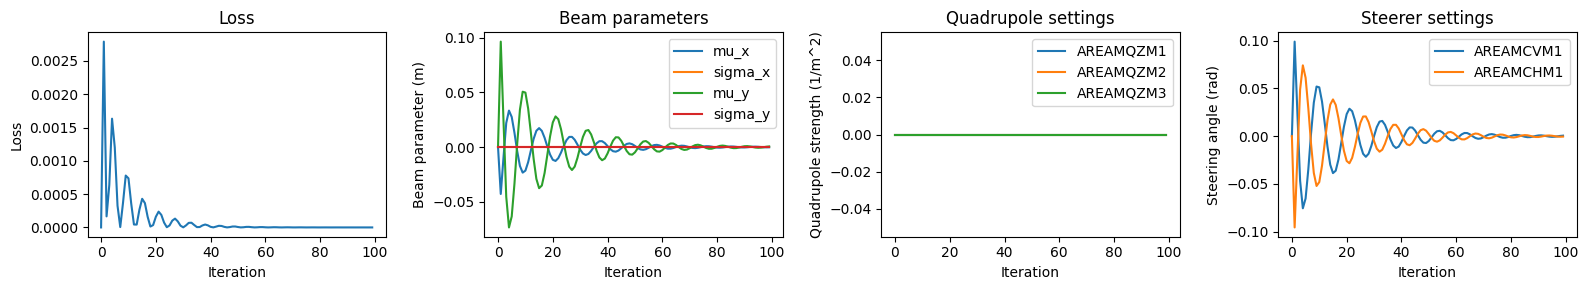

In [15]:
plt.figure(figsize=(16, 3))

plt.subplot(1, 4, 1)
plt.plot(history["loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")

plt.subplot(1, 4, 2)
plt.plot([record[0] for record in history["beam_parameters"]], label="mu_x")
plt.plot([record[1] for record in history["beam_parameters"]], label="sigma_x")
plt.plot([record[2] for record in history["beam_parameters"]], label="mu_y")
plt.plot([record[3] for record in history["beam_parameters"]], label="sigma_y")
plt.xlabel("Iteration")
plt.ylabel("Beam parameter (m)")
plt.title("Beam parameters")
plt.legend()

plt.subplot(1, 4, 3)
plt.plot([record[0] for record in history["magnet_settings"]], label="AREAMQZM1")
plt.plot([record[1] for record in history["magnet_settings"]], label="AREAMQZM2")
plt.plot([record[3] for record in history["magnet_settings"]], label="AREAMQZM3")
plt.xlabel("Iteration")
plt.ylabel("Quadrupole strength (1/m^2)")
plt.title("Quadrupole settings")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot([record[2] for record in history["magnet_settings"]], label="AREAMCVM1")
plt.plot([record[4] for record in history["magnet_settings"]], label="AREAMCHM1")
plt.xlabel("Iteration")
plt.ylabel("Steering angle (rad)")
plt.title("Steerer settings")
plt.legend()

plt.tight_layout()
plt.show()

Success! 🎉 We can observe that the optimisation converges to a solution that is close to the target beam parameters.

**However**, we can also observe that the quadrupole converges very slowly, indicating that the learning rate is too small, while the steerers keep overshooting the target, indicating that the learning rate is too large. This is a common problem in gradient-based optimisation caused by the very different scales of `k1` and `angle`, and can be solved by **normalising** the parameters under optimisation.

## Normalising parameters in gradient-based optimisation

In the following example we demonstrate how to **normalise** the parameters under optimisation with _Cheetah_. The same principle can also be applied to other custom mechanisms one might like to build around the lattice optimisation process, e.g. to add custom constraints, coupled parameters, etc.

To achieve this, we wrap the lattice section in a `torch.nn.Module` and define a `forward` function that applies the normalisation to the parameters before passing them to the lattice section.

**Note** that this time, simply for the fun of it, we also start with randomly initialised magnet settings.


In [16]:
class NormalizedARESExperimentalArea(nn.Module):
    """
    Wrapper around the AREA experimental area that holds normalised versions of the
    magnet settings as its trainable parameters.
    """

    QUADRUPOLE_LIMIT = 5.0
    STEERER_LIMIT = 6.1782e-3

    def __init__(self) -> None:
        super().__init__()
        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # self.normalized_quadrupole_strengths = nn.Parameter(
        #     torch.tensor([10.0, -10.0, 10.0]) / self.QUADRUPOLE_LIMIT
        # )
        # self.normalized_steering_angles = nn.Parameter(
        #     torch.tensor([1e-3, -1e-3]) / self.STEERER_LIMIT
        # )

        self.normalized_quadrupole_strengths = nn.Parameter(torch.randn(3) * 2 - 1)
        self.normalized_steering_angles = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, incoming_beam: cheetah.Beam):
        self.ares_ea.AREAMQZM1.k1 = (
            self.normalized_quadrupole_strengths[0] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMQZM2.k1 = (
            self.normalized_quadrupole_strengths[1] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCVM1.angle = (
            self.normalized_steering_angles[0] * self.STEERER_LIMIT
        )
        self.ares_ea.AREAMQZM3.k1 = (
            self.normalized_quadrupole_strengths[2] * self.QUADRUPOLE_LIMIT
        )
        self.ares_ea.AREAMCHM1.angle = (
            self.normalized_steering_angles[1] * self.STEERER_LIMIT
        )

        return self.ares_ea.track(incoming_beam)

In [17]:
normalized_ares_ea = NormalizedARESExperimentalArea()

We then redefine the `train` function to use the `torch.nn.Module` instead of the lattice section directly.

**Note** that we also chose to apply normalisation to the beam parameters. This is not strictly necessary, but can help to improve the stability of the optimisation process.


In [18]:
def train_normalized(num_steps: int, target_beam_parameters: torch.Tensor):
    beam_parameter_history = []
    magnet_setting_history = []
    loss_history = []

    optimizer = torch.optim.Adam(normalized_ares_ea.parameters(), lr=1e-1)

    for _ in range(num_steps):
        optimizer.zero_grad()

        outgoing_beam = normalized_ares_ea(incoming_beam)
        observed_beam_parameters = torch.stack(
            [
                outgoing_beam.mu_x,
                outgoing_beam.sigma_x,
                outgoing_beam.mu_y,
                outgoing_beam.sigma_y,
            ]
        )
        loss = F.mse_loss(
            observed_beam_parameters / 2e-3, target_beam_parameters / 2e-3
        )

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(observed_beam_parameters.detach().numpy())
        magnet_setting_history.append(
            torch.stack(
                [
                    normalized_ares_ea.ares_ea.AREAMQZM1.k1,
                    normalized_ares_ea.ares_ea.AREAMQZM2.k1,
                    normalized_ares_ea.ares_ea.AREAMCVM1.angle,
                    normalized_ares_ea.ares_ea.AREAMQZM3.k1,
                    normalized_ares_ea.ares_ea.AREAMCHM1.angle,
                ]
            )
            .detach()
            .numpy()
        )

        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "magnet_settings": magnet_setting_history,
    }
    return history

Now we run or new `train_normalized` function with the same target beam as before.


In [19]:
history = train_normalized(num_steps=200, target_beam_parameters=torch.zeros(4))

Then we plot the evolution of the optimisation process again.


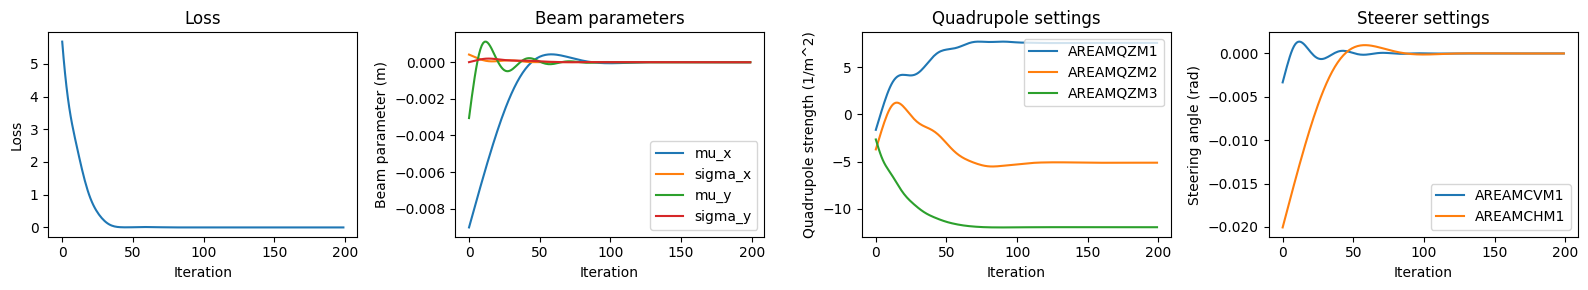

In [20]:
plt.figure(figsize=(16, 3))

plt.subplot(1, 4, 1)
plt.plot(history["loss"])
# plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")

plt.subplot(1, 4, 2)
plt.plot([record[0] for record in history["beam_parameters"]], label="mu_x")
plt.plot([record[1] for record in history["beam_parameters"]], label="sigma_x")
plt.plot([record[2] for record in history["beam_parameters"]], label="mu_y")
plt.plot([record[3] for record in history["beam_parameters"]], label="sigma_y")
plt.xlabel("Iteration")
plt.ylabel("Beam parameter (m)")
plt.title("Beam parameters")
plt.legend()

plt.subplot(1, 4, 3)
plt.plot([record[0] for record in history["magnet_settings"]], label="AREAMQZM1")
plt.plot([record[1] for record in history["magnet_settings"]], label="AREAMQZM2")
plt.plot([record[3] for record in history["magnet_settings"]], label="AREAMQZM3")
plt.xlabel("Iteration")
plt.ylabel("Quadrupole strength (1/m^2)")
plt.title("Quadrupole settings")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot([record[2] for record in history["magnet_settings"]], label="AREAMCVM1")
plt.plot([record[4] for record in history["magnet_settings"]], label="AREAMCHM1")
plt.xlabel("Iteration")
plt.ylabel("Steering angle (rad)")
plt.title("Steerer settings")
plt.legend()

plt.tight_layout()
plt.show()

As you can see this already looks much better than it did without normalisation.


# Gradient-based System Identification

The same principle can be applied to system identification tasks. In the following example we learn how to use _Cheetah_ for system identification at the example of determining the transverse misalignments of the three quadrupoles in the experimental area at the _ARES_ accelerator facility at DESY.

To determine the misalignments we need a dataset of magnet settings and the corresponding beam parameters for different settings of the quadrupoles. Typically, dedicated quadrupole scans are performed to collect such a dataset, which makes determining the misalignments comparatively easy. One advantage of using gradient-based optimisation for system identification is that it can easily be done one messy data as well. Such messy data can be collected parasitically during regular operation of the accelerator, in effect requiring no beam time.

Here we load a dataset generated by a reinforcement learning agent tuning the magnets in the EA towards a target beam. Note that this dataset would typically come from the real accelerator, but in this case we load a simulated dataset to enable us to check the identified misalignments against their ground truth values.


In [21]:
# Load data from an arbitrary tuning run
with open("rl_sim_33.pkl", "rb") as f:
    rl_data_sim = pickle.load(f)

Similar to the previous example, we perform gradient-based optimisation of the misalignments in the Cheetah model until the model best matches our observations from the real accelerator. To this end, the optimisation problem is again wrapped in a `torch.nn.Module` to enable normalisation of the parameters under optimisation.

Note that the Cheetah model requires an incoming beam. In a real-world scenario this is not necesarily known, while the transverse position of the incoming beam affects the model and thereby the determined misalignments. Ideally one might have information on the incoming beam from prior measurements (e.g. identification through Cheetah) or simulations. In this case we assume we know the incoming beam exactly and use the same beam as in the dataset. Further below, we show that this method still works well even if the incoming beam is not known exactly.


In [22]:
# Load ARES lattice and wrap it in normalisation nn.Module


class NormalizedARESEAMisalignments(nn.Module):
    """
    Wrapper around the ARES experimental area lattice that normalises the
    quadrupole misalignments.
    """

    MAX_MISALIGNMENT = 0.5e-3  # 0.5 mm

    def __init__(
        self,
        incoming: Literal[
            "rl_sim_data", "centered_rl_sim_data", "centered_astra", "uncentered_astra"
        ] = "centered_astra",
    ):
        super().__init__()

        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # Load a beam that's close to a design beam and move it to zero mu. Zero mu is
        # assumed because we need to define origin somehow and at ARES ballistic
        # trajectory is preferred.
        if incoming == "rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(incoming_parameters[1], dtype=torch.float32),
                mu_px=torch.tensor(incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(incoming_parameters[3], dtype=torch.float32),
                mu_py=torch.tensor(incoming_parameters[4], dtype=torch.float32),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_px=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_py=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_tau=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(0.0),
                mu_px=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_py=torch.tensor(0.0),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_px=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_py=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_tau=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_astra":
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_px=torch.tensor(0.0),
                mu_py=torch.tensor(0.0),
            )
        elif incoming == "uncentered_astra":
            rl_sim_incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(rl_sim_incoming_parameters[1], dtype=torch.float32),
                mu_px=torch.tensor(rl_sim_incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(rl_sim_incoming_parameters[3], dtype=torch.float32),
                mu_py=torch.tensor(rl_sim_incoming_parameters[4], dtype=torch.float32),
            )
        else:
            raise ValueError(f"Unknown incoming beam {incoming}")

        self.normalized_misalignments_q1 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q2 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q3 = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, magnet_settings):
        # Set the magnet settings as they were in the ground truth sample
        self.ares_ea.AREAMQZM1.k1 = magnet_settings[..., 0]
        self.ares_ea.AREAMQZM2.k1 = magnet_settings[..., 1]
        self.ares_ea.AREAMCVM1.angle = magnet_settings[..., 2]
        self.ares_ea.AREAMQZM3.k1 = magnet_settings[..., 3]
        self.ares_ea.AREAMCHM1.angle = magnet_settings[..., 4]

        # Set the misalignments based on the normalised misalignments
        self.ares_ea.AREAMQZM1.misalignment = (
            self.normalized_misalignments_q1 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM2.misalignment = (
            self.normalized_misalignments_q2 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM3.misalignment = (
            self.normalized_misalignments_q3 * self.MAX_MISALIGNMENT
        )

        return self.ares_ea.track(self.incoming_beam)

The `train` function below works much the same as the one used for the magnet setting optimisation. However now, the loss is computed as the error between the outgoing beam parameters from the Cheetah model and the observed beam parameters from the dataset.

Note that unlike in the previous example, it makes sense to compute the loss over batches of data, which increases optimisation speed and decreases the risk of getting stuck in local minima. This is only possible thanks to Cheetah's native support for vectorised operations.


In [23]:
def tensor_batched(tensor: torch.Tensor, batch_size: int) -> Iterator[torch.Tensor]:
    """Yield batched slices of a tensor with a given batch size."""
    for i in range(0, tensor.size(0), batch_size):
        yield tensor[i : i + batch_size]

In [24]:
def train_normalized(model: nn.Module, num_epochs: int, data: dict) -> dict:
    misalignment_q1_history = []
    misalignment_q2_history = []
    misalignment_q3_history = []
    beam_parameter_history = []
    loss_history = []

    magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
    measured_beams = torch.tensor([obs["beam"] for obs in data["observations"]])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for _ in trange(num_epochs):
        epoch_misalignment_q1_history = []
        epoch_misalignment_q2_history = []
        epoch_misalignment_q3_history = []
        epoch_beam_parameter_history = []
        epoch_loss_history = []

        magnet_settings, measured_beams = shuffle(magnet_settings, measured_beams)
        magnet_settings_2, measured_beams_2 = shuffle(magnet_settings, measured_beams)

        optimizer.zero_grad()

        for (
            magnet_setting_batch,
            measured_beam_batch,
            magnet_setting_2_batch,
            measured_beam_2_batch,
        ) in zip(
            tensor_batched(magnet_settings, 10),
            tensor_batched(measured_beams, 10),
            tensor_batched(magnet_settings_2, 10),
            tensor_batched(measured_beams_2, 10),
        ):
            outgoing_beam_batch = model(magnet_setting_batch)
            simulated_beam_batch = torch.stack(
                [outgoing_beam_batch.mu_x, outgoing_beam_batch.mu_y], dim=1
            )
            outgoing_beam_2_batch = model(magnet_setting_2_batch)
            simulated_beam_2_batch = torch.stack(
                [outgoing_beam_2_batch.mu_x, outgoing_beam_2_batch.mu_y], dim=1
            )
            measured_beam_change_batch = (measured_beam_2_batch - measured_beam_batch)[
                :, [0, 2]
            ]
            simulated_beam_change_batch = simulated_beam_2_batch - simulated_beam_batch
            loss = F.mse_loss(
                simulated_beam_change_batch / 2e-3, measured_beam_change_batch / 2e-3
            )

            loss.backward()

            optimizer.step()

            epoch_loss_history.append(loss.detach().numpy())
            epoch_beam_parameter_history.append(simulated_beam_batch.detach().numpy())
            epoch_misalignment_q1_history.append(
                model.ares_ea.AREAMQZM1.misalignment.detach().numpy()
            )
            epoch_misalignment_q2_history.append(
                model.ares_ea.AREAMQZM2.misalignment.detach().numpy()
            )
            epoch_misalignment_q3_history.append(
                model.ares_ea.AREAMQZM3.misalignment.detach().numpy()
            )

        # Log epoch history
        loss_history.append(np.mean(epoch_loss_history))
        beam_parameter_history.append(
            np.mean(np.vstack(epoch_beam_parameter_history), axis=0)
        )
        misalignment_q1_history.append(
            np.mean(np.stack(epoch_misalignment_q1_history), axis=0)
        )
        misalignment_q2_history.append(
            np.mean(np.stack(epoch_misalignment_q2_history), axis=0)
        )
        misalignment_q3_history.append(
            np.mean(np.stack(epoch_misalignment_q3_history), axis=0)
        )

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "misalignment_q1": misalignment_q1_history,
        "misalignment_q2": misalignment_q2_history,
        "misalignment_q3": misalignment_q3_history,
    }
    return history

The we plot the training history again.


In [25]:
def plot_training(
    history: dict, ground_truth: np.ndarray | None = None, save_path: str | None = None
) -> None:
    fig, axs = plt.subplots(3, 1, figsize=(3.5, 3.8), sharex=True)

    axs[0].plot(history["loss"])
    axs[0].set_ylabel("Loss")

    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FF6F61",
    )
    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#6B5B95",
    )
    axs[1].plot(
        [record[0] * 1e3 for record in history["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#88B04B",
    )
    if ground_truth is not None:
        axs[1].axhline(
            ground_truth[0] * 1e3, color="tab:blue", linestyle="--", c="#FF6F61"
        )
        axs[1].axhline(
            ground_truth[2] * 1e3, color="tab:orange", linestyle="--", c="#6B5B95"
        )
        axs[1].axhline(
            ground_truth[4] * 1e3, color="tab:green", linestyle="--", c="#88B04B"
        )
    axs[1].set_ylabel("x misalignment (mm)")
    axs[1].legend(ncol=3)

    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q1"]],
        label=r"$Q_1$",
        linestyle="-",
        c="#FFD700",
    )
    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q2"]],
        label=r"$Q_2$",
        linestyle="-",
        c="#40E0D0",
    )
    axs[2].plot(
        [record[1] * 1e3 for record in history["misalignment_q3"]],
        label=r"$Q_3$",
        linestyle="-",
        c="#FF7E5F",
    )
    if ground_truth is not None:
        axs[2].axhline(
            ground_truth[1] * 1e3, color="tab:blue", linestyle="--", c="#FFD700"
        )
        axs[2].axhline(
            ground_truth[3] * 1e3, color="tab:orange", linestyle="--", c="#40E0D0"
        )
        axs[2].axhline(
            ground_truth[5] * 1e3, color="tab:green", linestyle="--", c="#FF7E5F"
        )
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("y misalignment (mm)")
    axs[2].legend(ncol=3)

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path)

    plt.show()

In [26]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history_7 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_20981/2243841168.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
100%|██████████| 500/500 [00:41<00:00, 11.97it/s]


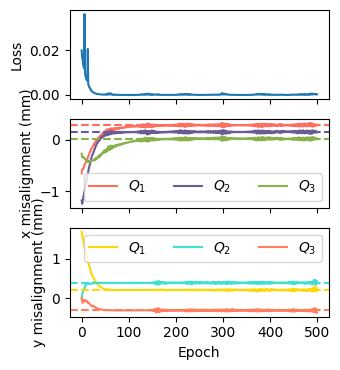

In [27]:
plot_training(history_7, ground_truth=rl_data_sim["observations"][0]["misalignments"])

We observe that the misalignments in the Cheetah model converge towards the known ground truth misalignments. This demonstrates that gradient-based optimisation can be used for system identification tasks with _Cheetah_.

However, as previously mentioned, the incoming beam is rarely known exactly in real-world scenarios. In the following assume a beam that is located in origin of the transverse plane. One might interpret this as assuming that the beam present in the dataset represents the golden orbit, and the goal is to determine the misalignments with respect to this orbit. We can now run the same optimisation as before, but with the incoming beam set to the origin.


In [ ]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history_9 = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)

  4%|▍         | 20/500 [00:01<00:40, 11.80it/s]

And once again plot the training history.


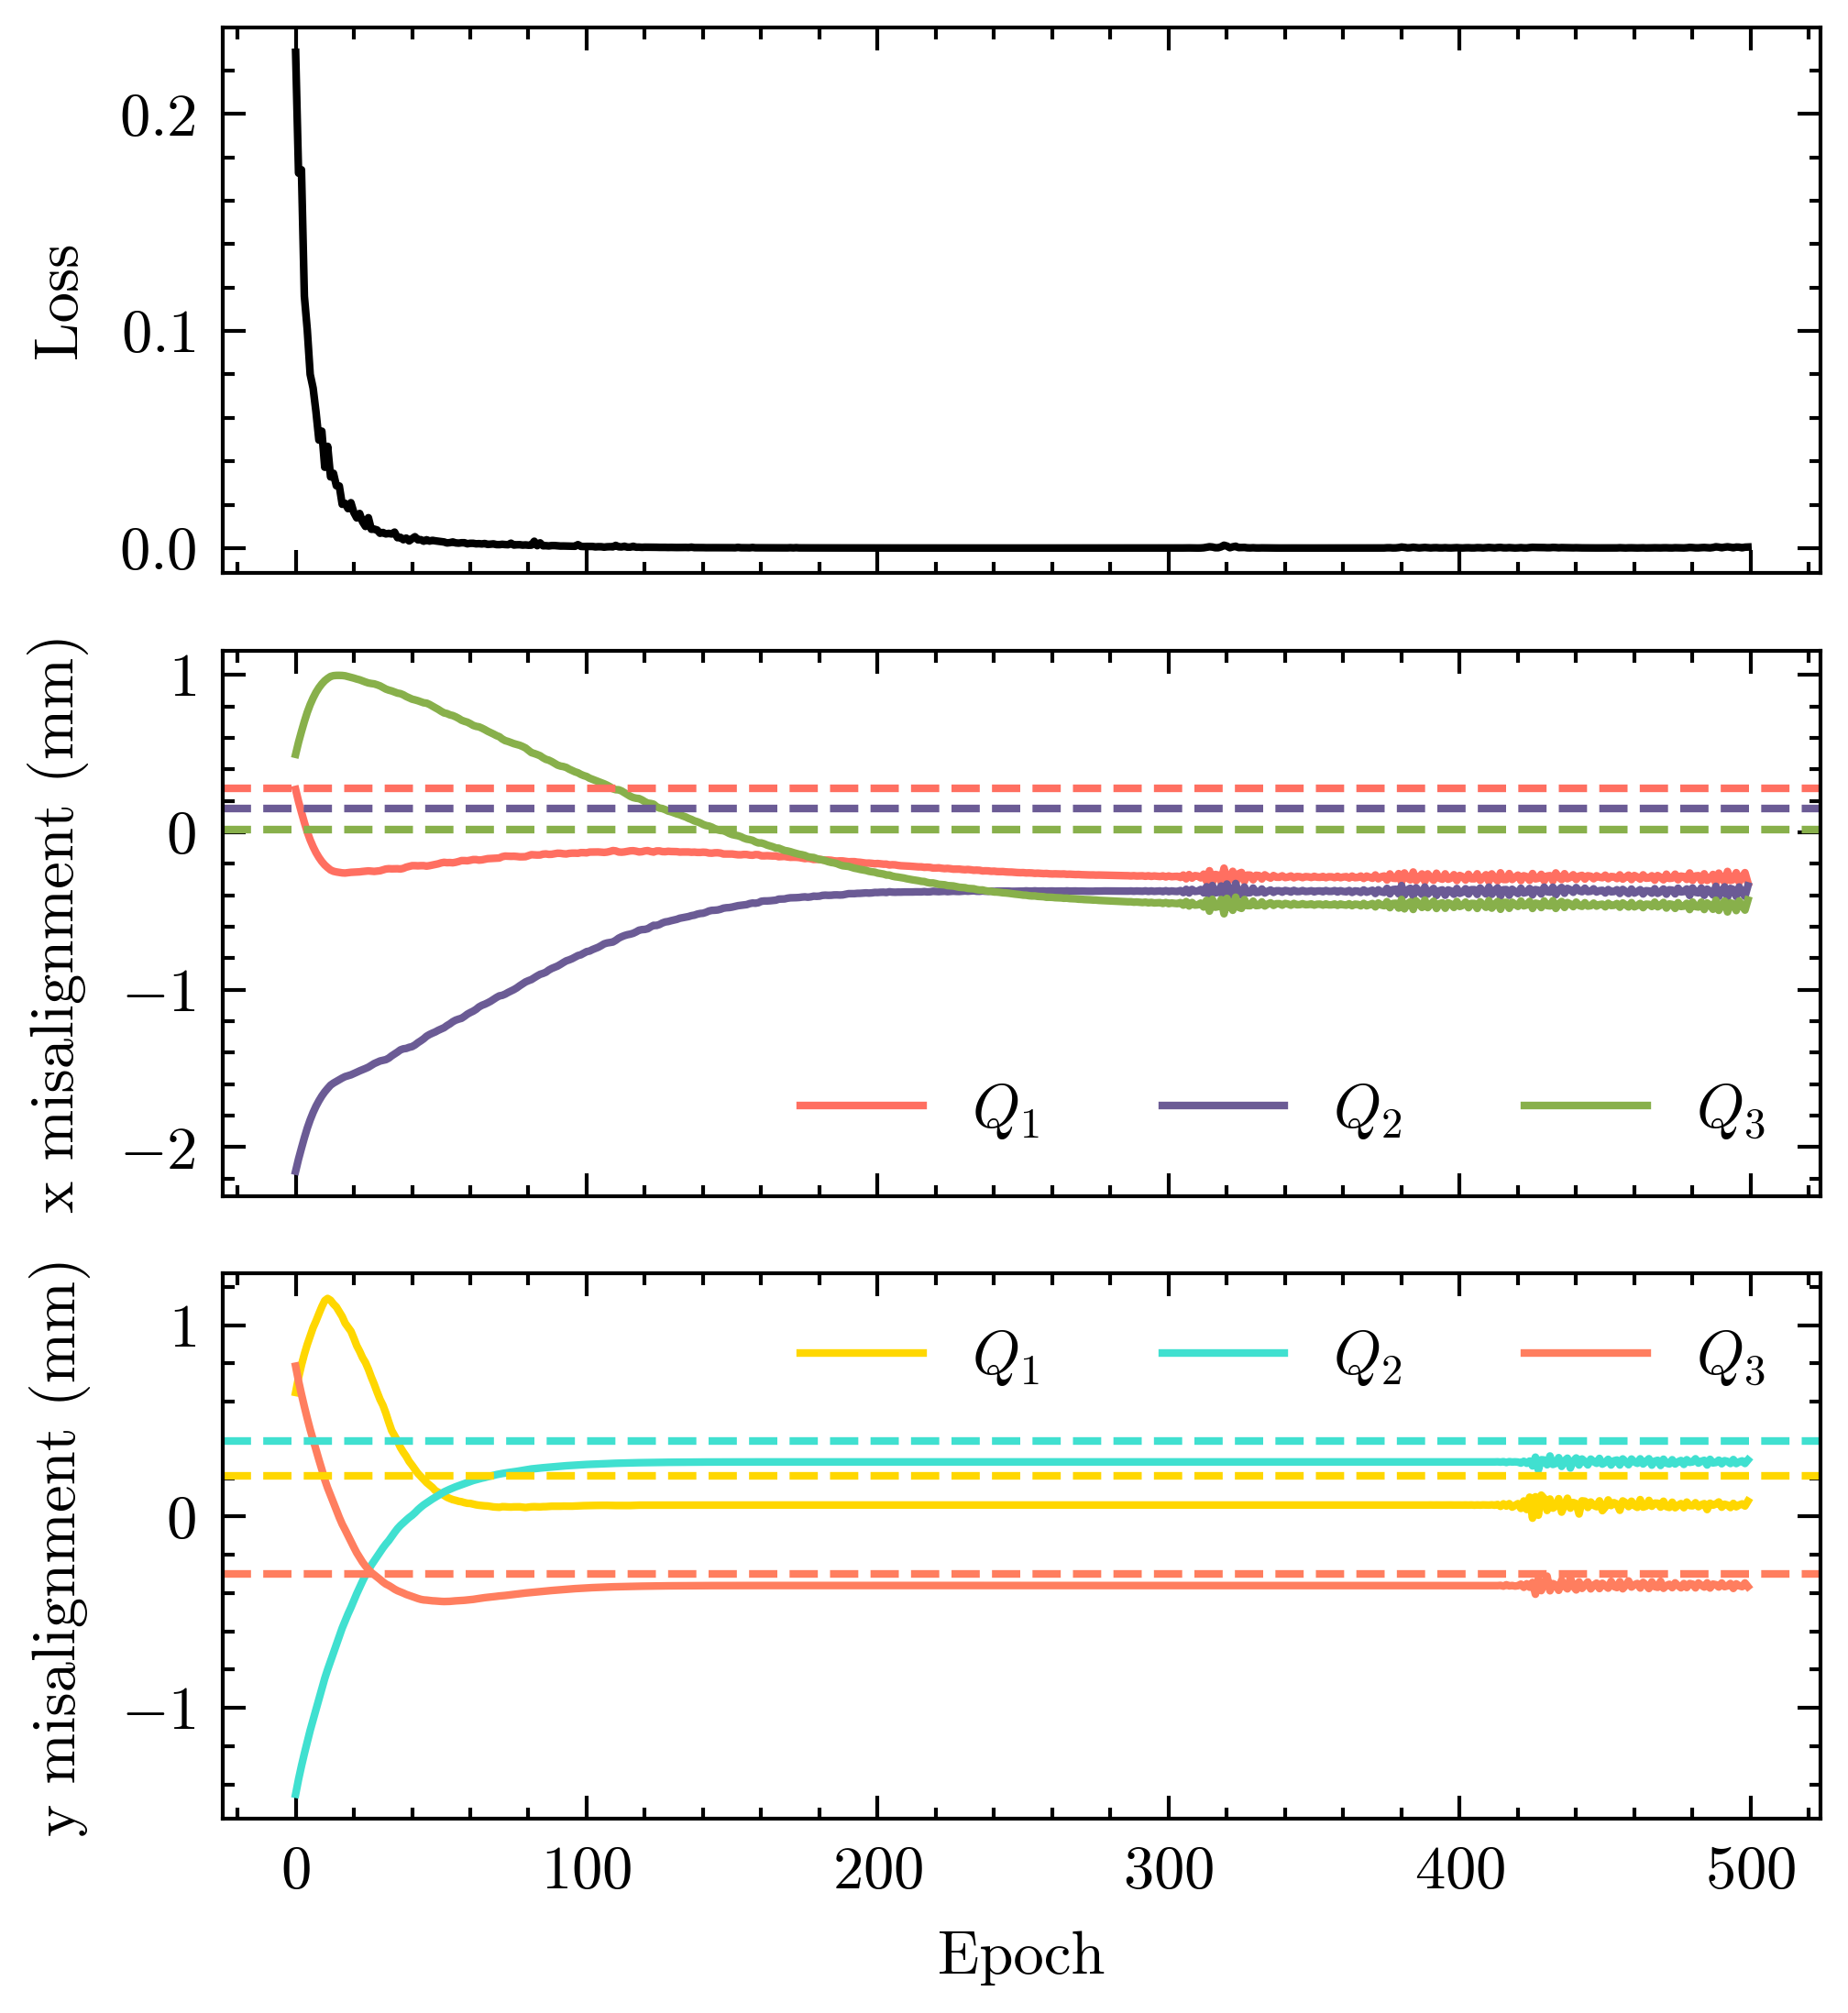

In [ ]:
plot_training(history_9, ground_truth=rl_data_sim["observations"][0]["misalignments"])

We find that as one would expect, the identified misalignments are now a shifted version of the ground truth misalignments. This information could now be used to move the quadrupole magnets onto the orbit present at the time the dataset was collected. If this was in fact the "golden orbit", the quadrupoles would then be aligned perfectly.
